In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


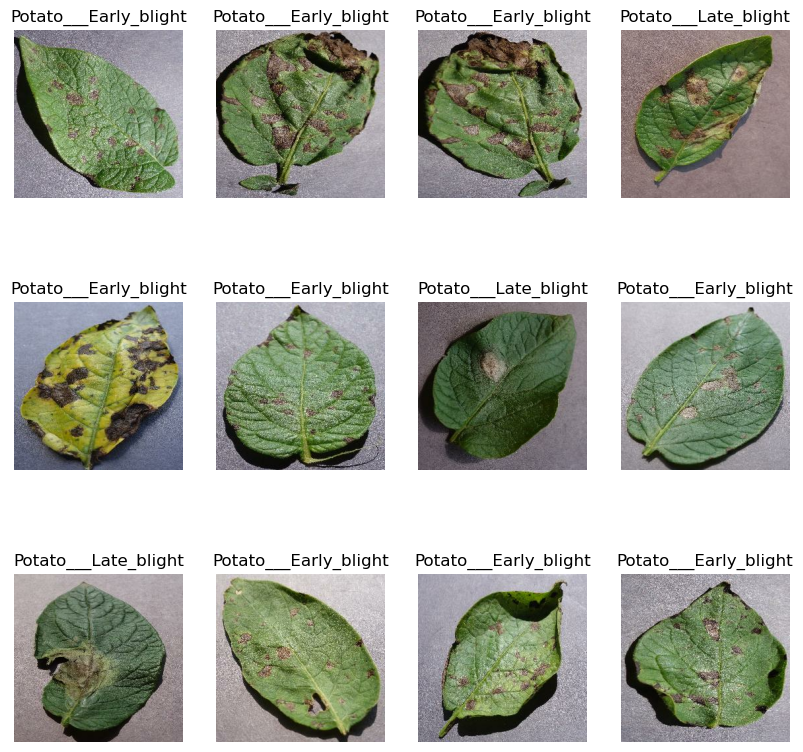

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [82]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
) 

Epoch 1/50
54/54 [==============================] - 132s 2s/step - loss: 0.0465 - accuracy: 0.9844 - val_loss: 0.0464 - val_accuracy: 0.9896
Epoch 2/50
54/54 [==============================] - 84s 2s/step - loss: 0.0656 - accuracy: 0.9757 - val_loss: 0.3093 - val_accuracy: 0.9115
Epoch 3/50
54/54 [==============================] - 93s 2s/step - loss: 0.0472 - accuracy: 0.9815 - val_loss: 0.4085 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 75s 1s/step - loss: 0.0385 - accuracy: 0.9855 - val_loss: 0.4476 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 73s 1s/step - loss: 0.0478 - accuracy: 0.9844 - val_loss: 0.0273 - val_accuracy: 0.9896
Epoch 6/50
54/54 [==============================] - 77s 1s/step - loss: 0.0503 - accuracy: 0.9774 - val_loss: 0.0614 - val_accuracy: 0.9688
Epoch 7/50
54/54 [==============================] - 78s 1s/step - loss: 0.0450 - accuracy: 0.9821 - val_loss: 0.2214 - val_accuracy: 0.9115
Epoch 8/50
54/54 [=

In [85]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print('Test accuracy:', test_accuracy)



8/8 [==============================] - 2s 302ms/step - loss: 0.0480 - accuracy: 0.9883
Test accuracy: 0.98828125


In [119]:
y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(model.predict(x).tolist())

y_true = np.array(y_true)
y_score = np.array(y_pred)

# convert class probabilities to binary class labels
y_pred_labels = np.argmax(y_score, axis=1)

# calculate AUC
auc = roc_auc_score(y_true, y_score, multi_class='ovo')
print('AUC:', auc)

1/1 [==============================] - 0s 346ms/step
AUC: 0.9984940551346803


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 301ms/step
predicted label: Potato___Early_blight


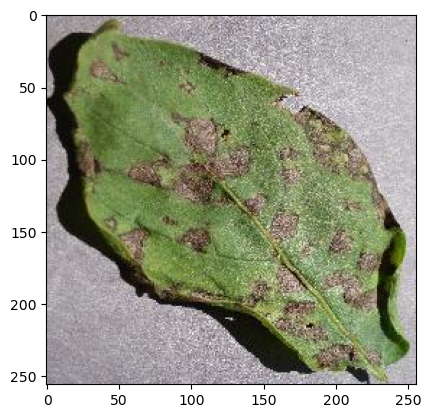

In [91]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 58ms/step


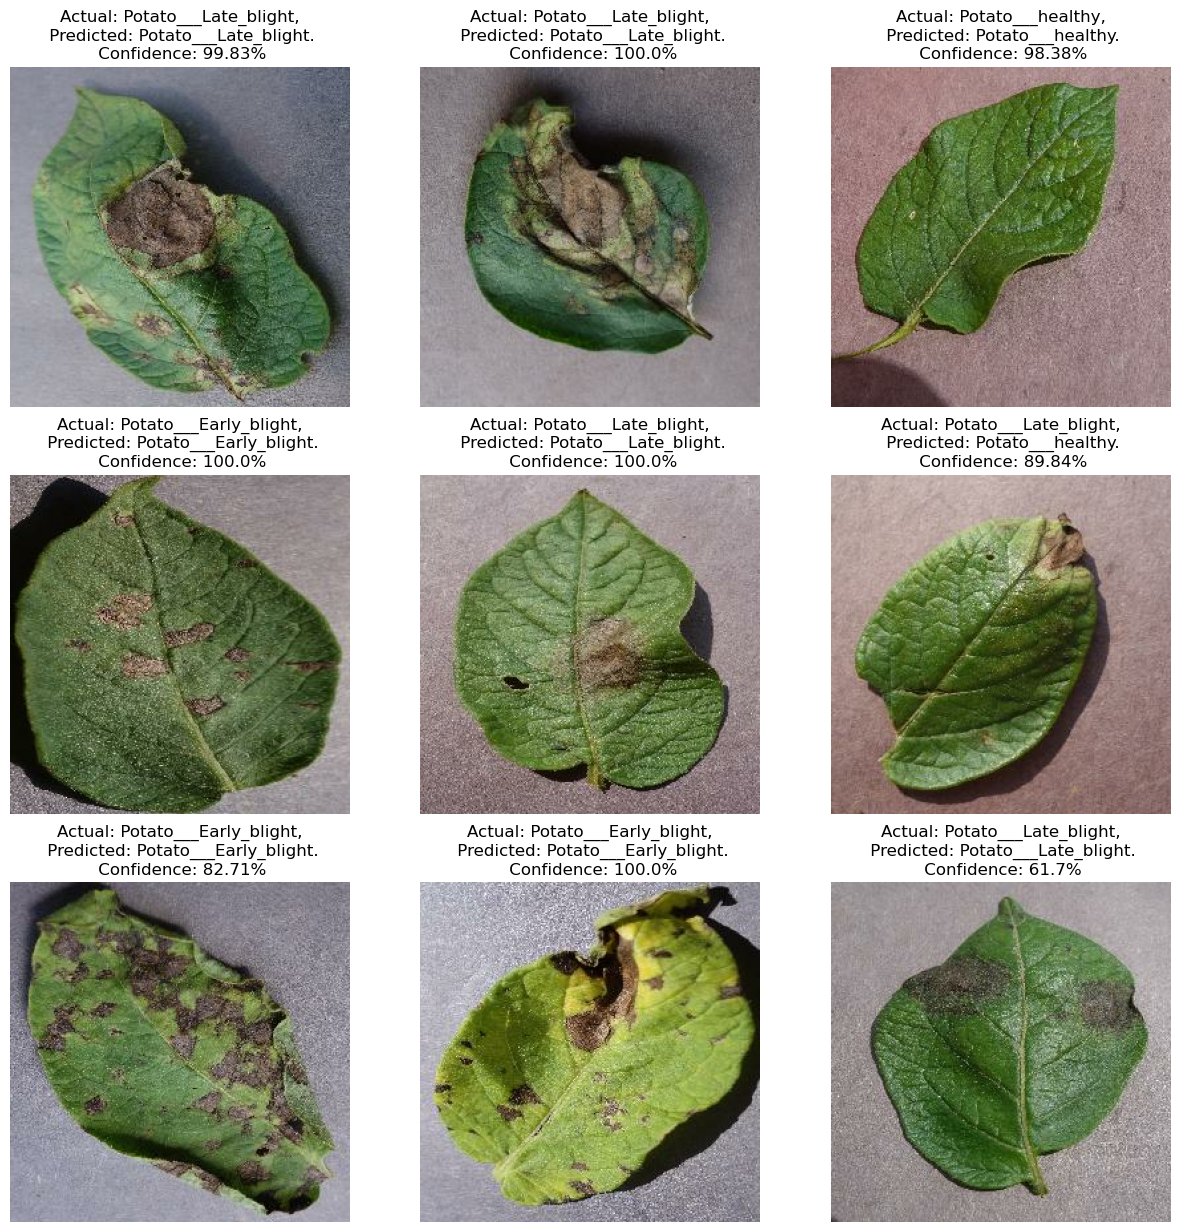

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [50]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [114]:
model.save("../potatoes.h5")

# SVM MODEL

In [111]:
import numpy as np
import os
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.color import rgb2gray

# Load dataset
data_dir = "PlantVillage"
categories = os.listdir(data_dir)
images = []
labels = []
for i, category in enumerate(categories):
    image_names = os.listdir(os.path.join(data_dir, category))
    for image_name in image_names:
        image = io.imread(os.path.join(data_dir, category, image_name))
        # Convert image to grayscale and resize
        image = rgb2gray(image)
        image = transform.resize(image, (128, 128))
        images.append(image.flatten())
        labels.append(i)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split dataset into training and testing sets
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train SVM model
svm_model = svm.SVC(probability=True, decision_function_shape='ovr')
svm_model.fit(X_train_SVM, y_train_SVM)

# Predict probabilities for test set
y_prob_SVM = svm_model.predict_proba(X_test_SVM)
# Apply softmax to get normalized probabilities
y_prob_SVM = np.apply_along_axis(lambda x: np.exp(x) / np.sum(np.exp(x)), 1, y_prob_SVM)

# Predict labels for test set
y_pred_SVM = svm_model.predict(X_test_SVM)

# Compute accuracy
accuracy = metrics.accuracy_score(y_test_SVM, y_pred_SVM)
print("Accuracy:", accuracy)


Accuracy: 0.851508120649652


In [66]:
precision = precision_score(y_test_SVM, y_pred_SVM, average='weighted')
recall = recall_score(y_test_SVM, y_pred_SVM, average='weighted')
f1 = f1_score(y_test_SVM, y_pred_SVM, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Precision: 0.8607628908820167
Recall: 0.851508120649652
F1 score: 0.8314200402080323


In [112]:
# Compute AUC
from sklearn.metrics import roc_auc_score

auc_score = metrics.roc_auc_score(y_test_SVM, y_prob_SVM, multi_class='ovo')
print("AUC score:", auc_score)


AUC score: 0.9009489883550034


# KNN MODEL

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle

# Set the path to the PlantVillage dataset
data_dir = 'PlantVillage'

# Create a list of all the image file paths
file_paths = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        file_paths.append((file_path, class_name))
        
# Shuffle the file paths
file_paths = shuffle(file_paths, random_state=42)

# Create a list of the images and their corresponding labels
images = []
labels = []
for file_path, class_name in file_paths:
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(class_name)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
train_images_KNN, test_images_KNN, train_labels_KNN, test_labels_KNN = train_test_split(images, labels, test_size=0.2, random_state=42)

# Flatten the image arrays
train_images_KNN = train_images_KNN.reshape(train_images_KNN.shape[0], -1)
test_images_KNN = test_images_KNN.reshape(test_images_KNN.shape[0], -1)

# Train the KNN classifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(train_images_KNN, train_labels_KNN)

# Make predictions on the test data
pred_labels_KNN = clf.predict(test_images_KNN)

# Calculate the accuracy of the model
accuracy = accuracy_score(test_labels_KNN, pred_labels_KNN)
print('Accuracy:', accuracy)

# Calculate the precision, recall, and F1 score of the model
precision = precision_score(test_labels_KNN, pred_labels_KNN, average='weighted')
recall = recall_score(test_labels_KNN, pred_labels_KNN, average='weighted')
f1 = f1_score(test_labels_KNN, pred_labels_KNN, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)


Accuracy: 0.6728538283062645
Precision: 0.8073366569033977
Recall: 0.6728538283062645
F1 score: 0.6406087421194562


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [121]:
proba_KNN = clf.predict_proba(test_images_KNN)
auc_KNN = roc_auc_score(test_labels_KNN, proba_KNN, multi_class='ovr')
print('AUC score:', auc_KNN)

AUC score: 0.9491617060612159


# RANDOM FOREST MODEL 

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle

# Set the path to the PlantVillage dataset
data_dir = 'PlantVillage'

# Create a list of all the image file paths
file_paths = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        file_paths.append((file_path, class_name))
        
# Shuffle the file paths
file_paths = shuffle(file_paths, random_state=42)

# Create a list of the images and their corresponding labels
images = []
labels = []
for file_path, class_name in file_paths:
    img = cv2.imread(file_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(class_name)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
train_images_RF, test_images_RF, train_labels_RF, test_labels_RF = train_test_split(images, labels, test_size=0.2, random_state=42)

# Flatten the image arrays
train_images_RF = train_images_RF.reshape(train_images.shape[0], -1)
test_images_RF = test_images_RF.reshape(test_images.shape[0], -1)

# Train the random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_images_RF, train_labels_RF)

# Make predictions on the test data
pred_labels_RF = clf.predict(test_images_RF)

# Calculate the accuracy of the model
accuracy = accuracy_score(test_labels_RF, pred_labels_RF)
print('Accuracy:', accuracy)

# Calculate the precision, recall and F1 score of the model
precision = precision_score(test_labels_RF, pred_labels_RF, average='weighted')
recall = recall_score(test_labels_RF, pred_labels_RF, average='weighted')
f1 = f1_score(test_labels_RF, pred_labels_RF, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)


Accuracy: 0.8700696055684455
Precision: 0.8781802381884506
Recall: 0.8700696055684455
F1 score: 0.8439847488041174


In [122]:
proba = clf.predict_proba(test_images_RF)
auc = roc_auc_score(test_labels_RF, proba, multi_class='ovr')
print('AUC:', auc)


AUC: 0.9491617060612159


# NAIVE BAYES MODEL

In [70]:
import numpy as np
import cv2
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define path to the dataset
dataset_path = "PlantVillage"

# Define the class labels
class_names = sorted(os.listdir(dataset_path))

# Define lists to hold the image data and labels
images = []
labels = []

# Load the image data and labels
for class_label in class_names:
    class_path = os.path.join(dataset_path, class_label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (32, 32)) # Resize the image to a fixed size
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale
        img = img.flatten() # Flatten the image into a 1D array
        images.append(img)
        labels.append(class_names.index(class_label))

# Split the dataset into training and testing sets
X_train_NB, X_test_NB, y_train_NB, y_test_NB = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_NB, y_train_NB)

# Make predictions on the test set
y_pred_NB = nb_classifier.predict(X_test_NB)



In [71]:
accuracy = accuracy_score(y_test_NB, y_pred_NB)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7819025522041764


In [72]:
precision = precision_score(y_test_NB, y_pred_NB, average='weighted')
recall = recall_score(y_test_NB, y_pred_NB, average='weighted')
f1 = f1_score(y_test_NB, y_pred_NB, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Precision: 0.8196032842907867
Recall: 0.7819025522041764
F1 score: 0.7963574497629505


In [123]:
y_score_NB = nb_classifier.predict_proba(X_test_NB)
auc_NB = roc_auc_score(np.array(y_test_NB), y_score_NB, multi_class='ovr')

print("AUC for Naive Bayes model: ", auc_NB)

AUC for Naive Bayes model:  0.8855276080096758
